## Importing modules

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import config, os
from utils import Check_Valid, MergeDF, BufferMergeDF
from shapely.validation import make_valid
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from shapely import wkt
from pyproj import Transformer
from shapely.ops import transform, polygonize
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## Loading border files

In [2]:
commerce_path = os.path.join(config.DATA_DIR, '상권 영역 좌표/서울시 상권분석서비스(영역-상권).shp')
hinterland_path = os.path.join(config.DATA_DIR, '상권 배후지 영역 좌표/서울시 상권분석서비스(영역-상권배후지).shp')
dong_path = os.path.join(config.DATA_DIR, '행정동 영역 좌표/서울시 상권분석서비스(영역-행정동).shp')
lake_path = os.path.join(config.DATA_DIR, '하천 구역/LSMD_CONT_UJ201_11_202512.shp')
gu_path = os.path.join(config.DATA_DIR, '자치구 영역 좌표', '서울시 상권분석서비스(영역-자치구).shp')
road_path = os.path.join(config.DATA_DIR, '(도로명주소)도로구간_서울/TL_SPRD_MANAGE_11_202511.shp')

commerce = gpd.read_file(commerce_path, encoding='utf-8')
hinterland = gpd.read_file(hinterland_path, encoding='utf-8')
dong = gpd.read_file(dong_path, encoding='utf-8')
lake = gpd.read_file(lake_path)
gu = gpd.read_file(gu_path)
road = gpd.read_file(road_path, encoding='cp949')

lake = lake.to_crs(commerce.crs)
road = road.to_crs(commerce.crs)

lake_col, road_col = lake.columns, road.columns

print("CRS Match:", True if commerce.crs == hinterland.crs == dong.crs == lake.crs == gu.crs == road.crs else False)
print("CRS:", commerce.crs)
gu_mapo = gu[gu.SIGNGU_NM == '마포구']
lake_mapo = lake.sjoin(gu_mapo, how='inner', predicate='intersects')[lake_col]
road_mapo = road.sjoin(gu_mapo, how='inner', predicate='intersects')[road_col]
commerce_mapo = commerce[commerce['SIGNGU_CD_'] == '마포구'].reset_index(drop=True)
hinterland_mapo = hinterland[hinterland['SIGNGU_CD_'] == '마포구'].reset_index(drop=True)
dong_mapo = dong[dong.ADSTRD_NM.isin(commerce_mapo.ADSTRD_CD_.unique().tolist())].reset_index(drop=True)

CRS Match: True
CRS: EPSG:5181


## Calculating square meter area of each polygon

In [3]:
seoul_commerce_mapo = commerce_mapo.copy()
seoul_hinterland_mapo = hinterland_mapo.copy()
seoul_dong_mapo = dong_mapo.copy()

seoul_commerce_mapo["area_m2"] = seoul_commerce_mapo.geometry.area
seoul_hinterland_mapo["area_m2"] = seoul_hinterland_mapo.geometry.area
seoul_dong_mapo["area_m2"] = seoul_dong_mapo.geometry.area

In [4]:
display(seoul_commerce_mapo.head(5))
display(seoul_hinterland_mapo.head(5))
display(seoul_dong_mapo.head(5))

,TRDAR_SE_C,TRDAR_SE_1,TRDAR_CD,TRDAR_CD_N,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,SIGNGU_CD_,ADSTRD_CD,ADSTRD_CD_,RELM_AR,geometry,area_m2
0,A,골목상권,3110566,경의선책거리,193685.0,450750.0,11440,마포구,11440660,서교동,156743.0,"POLYGON ((193830.531 450892.687, 193885.91 450...",156743.003975
1,R,전통시장,3130193,신수시장,194286.0,449527.0,11440,마포구,11440630,신수동,6691.0,"POLYGON ((194286.605 449572.532, 194293.07 449...",6691.418631
2,R,전통시장,3130192,동진시장,193538.0,451420.0,11440,마포구,11440710,연남동,4091.0,"POLYGON ((193531.845 451450.841, 193545.125 45...",4091.276634
3,R,전통시장,3130191,홍대 걷고싶은 거리,193388.0,450714.0,11440,마포구,11440660,서교동,58130.0,"POLYGON ((193586.215 450816.234, 193589.537 45...",58129.960204
4,R,전통시장,3130198,아현시장,195969.0,450765.0,11440,마포구,11440555,아현동,27671.0,"POLYGON ((195996.515 450827.227, 195998.712 45...",27670.920304


,ALLEY_TRDA,ALLEY_TR_1,XCNTS_VALU,YDNTS_VALU,SIGNGU_CD,SIGNGU_CD_,ADSTRD_CD,ADSTRD_CD_,RELM_AR,geometry,area_m2
0,3110585,마포경찰서,195959.0,450277.0,11440,마포구,11440555,아현동,402931.0,"POLYGON ((196029.66 449871.41, 196016.579 4498...",402930.560591
1,3110583,공덕래미안3차아파트,195805.0,449944.0,11440,마포구,11440555,아현동,271433.0,"POLYGON ((195860.38 449629.98, 195847.299 4496...",271433.136313
2,3110584,아현역 4번,195864.0,450839.0,11440,마포구,11440555,아현동,307230.0,"POLYGON ((195669.76 450611.18, 195656.679 4506...",307230.020917
3,3110588,한겨레신문사,196478.0,449823.0,11440,마포구,11440565,공덕동,453824.0,"POLYGON ((196391.89 449392.24, 196378.809 4493...",453823.915894
4,3110586,서울서부지방법원,196144.0,449968.0,11440,마포구,11440565,공덕동,674691.0,"POLYGON ((196040.34 449387.19, 196027.259 4493...",674691.033356


,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR,geometry,area_m2
0,11440555,아현동,195823.0,450258.0,744328.0,"POLYGON ((196437.302 450907.847, 196440.88 450...",7.443278e+05
1,11440565,공덕동,196284.0,449979.0,1019197.0,"POLYGON ((196605.824 450988.68, 196608.12 4509...",1.019197e+06
2,11440585,도화동,195502.0,448794.0,625018.0,"POLYGON ((195813.197 449219.136, 195814.753 44...",6.250183e+05
3,11440700,망원2동,191180.0,451056.0,676411.0,"POLYGON ((190829.315 450639.899, 190772.574 45...",6.764105e+05
4,11440710,연남동,193068.0,451501.0,647438.0,"POLYGON ((192677.686 452019.869, 192688.552 45...",6.474380e+05


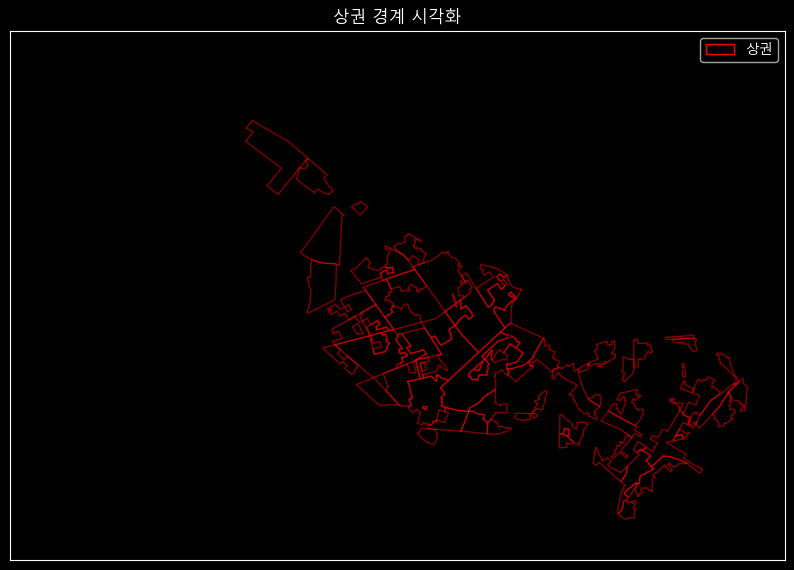

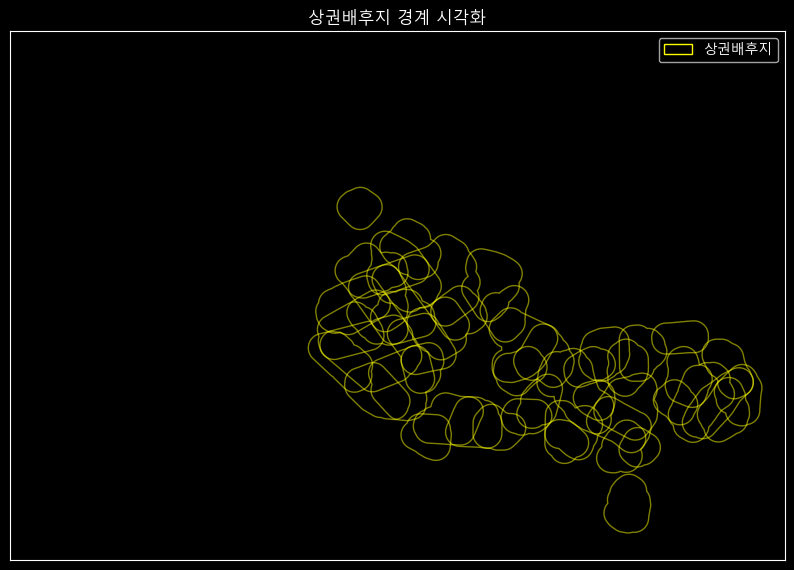

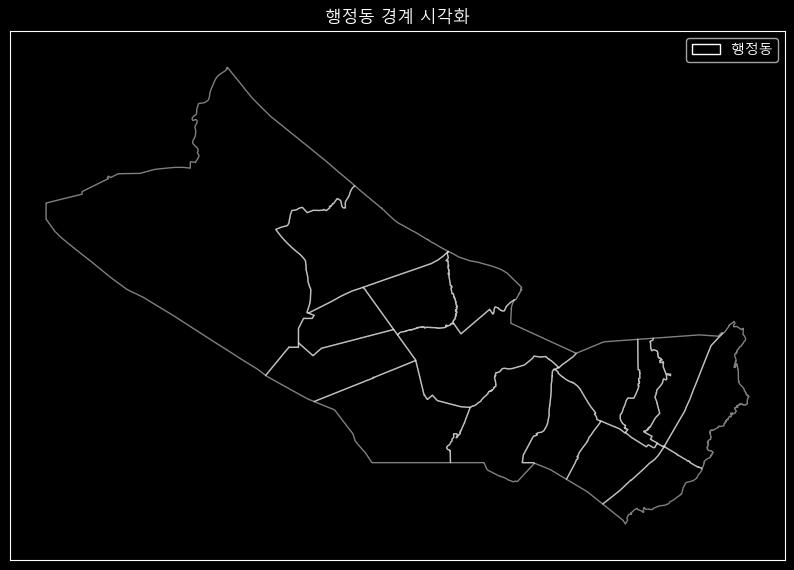

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
seoul_commerce_mapo.plot(ax=ax, color='none', edgecolor='red', alpha=0.5)
legend_elements = [
    Patch(facecolor='none', edgecolor='red', label='상권'),
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "상권 경계 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
seoul_hinterland_mapo.plot(ax=ax, color='none', edgecolor='yellow', alpha=0.5)
legend_elements = [
    Patch(facecolor='none', edgecolor='yellow', label='상권배후지'),
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "상권배후지 경계 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
seoul_dong_mapo.plot(ax=ax, color='none', edgecolor='white', alpha=0.5)
legend_elements = [
    Patch(facecolor='none', edgecolor='white', label='행정동'),
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "행정동 경계 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

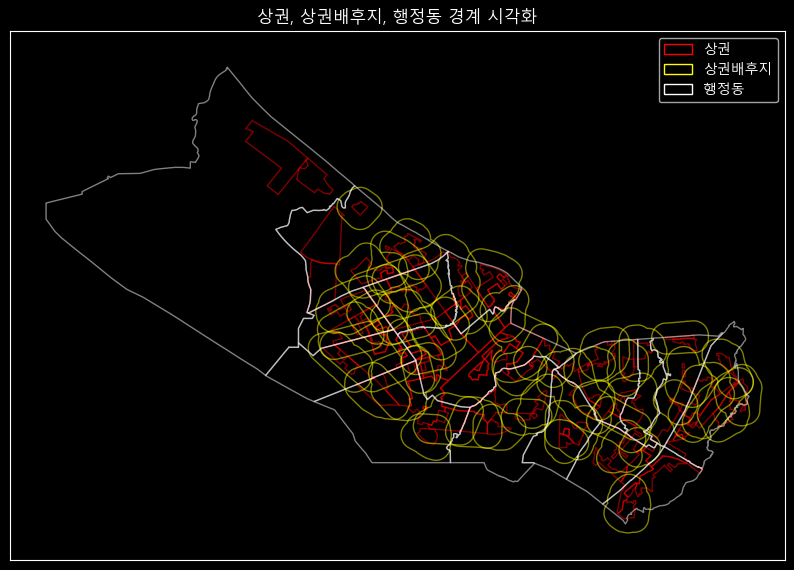

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
seoul_commerce_mapo.plot(ax=ax, color='none', edgecolor='red', alpha=0.5)
seoul_hinterland_mapo.plot(ax=ax, color='none', edgecolor='yellow', alpha=0.5)
seoul_dong_mapo.plot(ax=ax, color='none', edgecolor='white', alpha=0.5)
legend_elements = [
    Patch(facecolor='none', edgecolor='red', label='상권'),
    Patch(facecolor='none', edgecolor='yellow', label='상권배후지'),
    Patch(facecolor='none', edgecolor='white', label='행정동'),
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "상권, 상권배후지, 행정동 경계 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

## Calculating area divided by each border

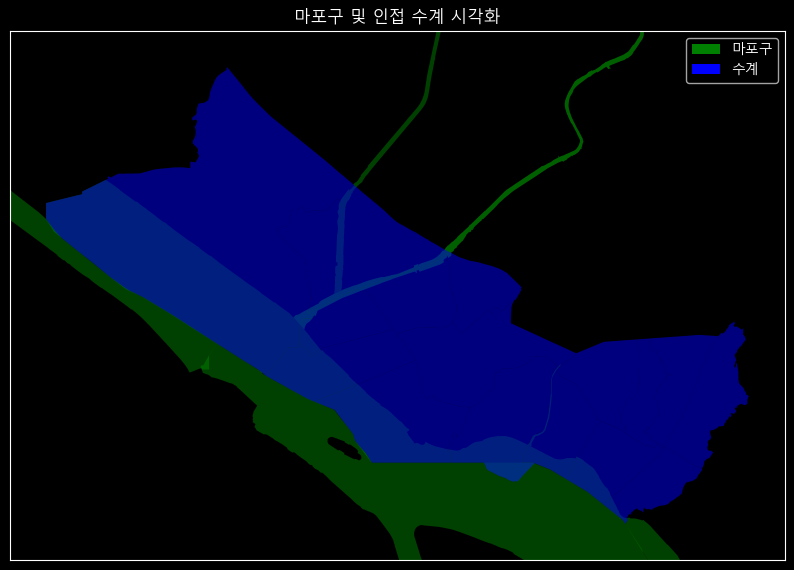

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
lake_mapo.plot(ax=ax, color='green', alpha=0.5)
seoul_dong_mapo.plot(ax=ax, color='blue', alpha=0.5)
legend_elements = [
    Patch(facecolor='green', label='마포구'),
    Patch(facecolor='blue', label='수계'),
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "마포구 및 인접 수계 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

In [13]:
lake_mapo

,ALIAS,REMARK,NTFDATE,COL_ADM_SE,SGG_OID,MNUM,geometry
2,None,ÇÑ°­(ÆÈ´ç´ï~ÇÏ±¸),None,11170,65,15001851117020200099UJB1000001001,"POLYGON ((195101.632 448254.203, 195103.589 44..."
36,None,None,20180621,11410,321,61100001141020180191UJB1000001001,"POLYGON ((190499.95 451117.796, 190502.75 4511..."
39,None,None,20101230,11440,341,61100001144020100477UJB1001230002,"POLYGON ((193144.079 449105.119, 193322.15 449..."
40,None,None,20140403,11440,339,61100001144020140120UJB1000403003,"POLYGON ((190499.95 451117.796, 190502.75 4511..."
41,None,None,20140403,11440,338,61100001144020140120UJB1000403002,"POLYGON ((191053.31 451439.577, 191063.28 4514..."
42,None,None,20140403,11440,337,61100001144020140120UJB1000403001,"POLYGON ((193747.036 449352.324, 193753.735 44..."
43,None,None,20200410,11440,673,15001851144020200100UJB1000001001,"POLYGON ((187069.705 452481.728, 187069.761 45..."
45,None,None,None,11500,369,15001851150020200100UJB1002020001,"POLYGON ((182082.898 455348.665, 182082.967 45..."
57,None,None,None,11560,641,15001851156020200101UJB1000001001,"POLYGON ((189213.44 450430.813, 189213.492 450..."


In [14]:
# 상권: TRDAR_CD, 상권배후지: ALLEY_TRDA, 행정동: ADSTRD_CD

comm_ = seoul_commerce_mapo[['TRDAR_CD', 'geometry']]
hint_ = seoul_hinterland_mapo[['ALLEY_TRDA', 'geometry']]
dong_ = seoul_dong_mapo[['ADSTRD_CD', 'geometry']]
lake_ = lake_mapo[['geometry']]

lines = [comm_.geometry.boundary.union_all(), hint_.geometry.boundary.union_all(), dong_.geometry.boundary.union_all(), lake_.geometry.boundary.union_all()]

combined_all_lines = gpd.GeoSeries(lines).union_all()

divided_polygons = list(polygonize(combined_all_lines))

all_segmented = gpd.GeoDataFrame(geometry=divided_polygons, crs=comm_.crs)

all_segmented['rep_point'] = all_segmented.geometry.representative_point()

all_segmented_mapped = all_segmented.set_geometry('rep_point')

all_segmented_mapped = all_segmented_mapped.sjoin(comm_, how='left', predicate='within')
all_segmented_mapped.drop(columns='index_right', inplace=True, errors='ignore')

all_segmented_mapped = all_segmented_mapped.sjoin(hint_, how='left', predicate='within')
all_segmented_mapped.drop(columns='index_right', inplace=True, errors='ignore')

all_segmented_mapped = all_segmented_mapped.sjoin(dong_, how='inner', predicate='within')
all_segmented_mapped.drop(columns='index_right', inplace=True, errors='ignore')

lake_regions = all_segmented_mapped.sjoin(lake_, how='inner', predicate='within')
all_segmented_mapped = all_segmented_mapped.drop(lake_regions.index, axis=0)

all_segmented_final = all_segmented_mapped.set_geometry('geometry')

all_segmented_final = all_segmented_final.groupby(all_segmented_final.index).agg({
    'geometry': 'first',
    'rep_point': 'first',
    'TRDAR_CD': lambda x: list(set(x.dropna())),
    'ALLEY_TRDA': lambda x: list(set(x.dropna())),
    'ADSTRD_CD': 'first'
})

all_segmented_final = gpd.GeoDataFrame(
    all_segmented_final,
    geometry='geometry',
    crs=comm_.crs
)

# leave areas over 400m^2
all_segmented_final['area_m2'] = all_segmented_final.geometry.area
all_segmented_final = all_segmented_final[all_segmented_final.area_m2 > 400]

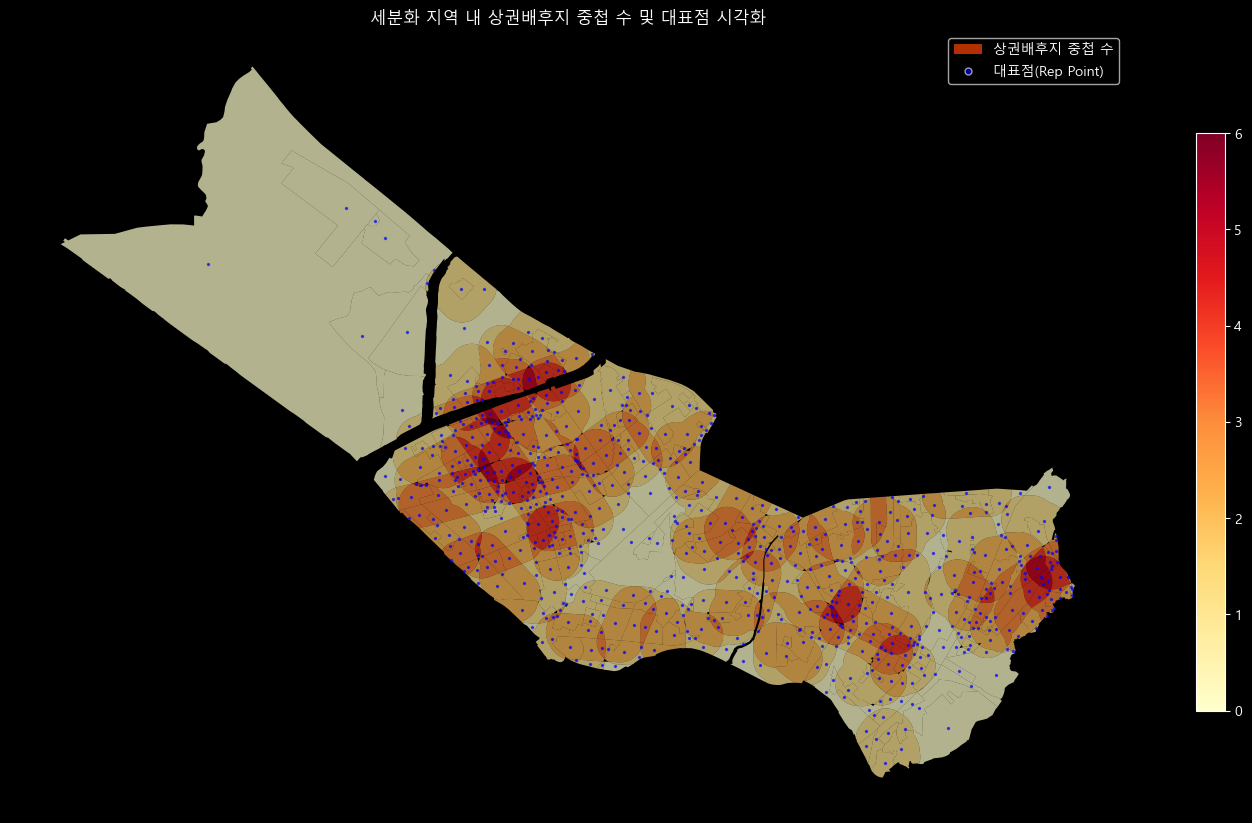

In [18]:
fig, ax = plt.subplots(figsize=(18, 15))
all_segmented_final.plot(ax=ax, edgecolor='black', linewidth=0.3, facecolor='none', alpha=0.3)
all_segmented_final['hint_count'] = all_segmented_final['ALLEY_TRDA'].map(len)
all_segmented_final.plot(ax=ax, column='hint_count', cmap='YlOrRd', legend=True, alpha=0.7,
                         legend_kwds={
                           'shrink': 0.5,
                           'aspect': 20,
                           'orientation': "vertical"
                         })
all_segmented_final['rep_point'] = all_segmented_final.geometry.representative_point()
all_segmented_final.set_geometry('rep_point').plot(
    ax=ax,
    color='blue',      # 점의 색상 (눈에 잘 띄게 파란색 추천)
    markersize=2,      # 점의 크기 (조각이 작으면 1~2 정도가 적당)
    alpha=0.6          # 점의 투명도
)
legend_elements = [
    Patch(facecolor='#FF4500', alpha=0.7, label='상권배후지 중첩 수'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
           markersize=5, linestyle='None', alpha=0.6, label='대표점(Rep Point)')
]
ax.legend(handles=legend_elements)
ax.axis('off')
title = "세분화 지역 내 상권배후지 중첩 수 및 대표점 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()
all_segmented_final.drop(['area_m2','hint_count'], axis=1, inplace=True)

## Data Gathering

In [15]:
print(f'원본 상권 수: {len(seoul_commerce_mapo.TRDAR_CD)}')

data_topics = ['길단위인구', '상주인구', '소득소비', '아파트', '점포', '직장인구', '집객시설', '추정매출']

commerce_df = {}; hinterland_df = {}; dong_df = {}

cv = Check_Valid(
  source_data = seoul_commerce_mapo,
  source_col = 'TRDAR_CD',
  target_col = ['상권_코드']
)

hv = Check_Valid(
  source_data = seoul_hinterland_mapo,
  source_col = 'ALLEY_TRDA',
  target_col = ['상권배후지_코드', '상권_코드']
)

dv = Check_Valid(
  source_data = seoul_dong_mapo,
  source_col = 'ADSTRD_CD',
  target_col = ['행정동_코드']
)

for t in data_topics:
  commerce_df[t] = cv.print_out_valid(t, '서울 상권분석서비스(상권 기준)')
  hinterland_df[t] = hv.print_out_valid(t, '서울 상권분석서비스(상권 배후지 기준)')
  dong_df[t] = dv.print_out_valid(t, '서울 상권분석서비스(행정동 기준)')

원본 상권 수: 77
서울시 상권분석서비스(길단위인구-상권) valid 상권 수: 77
서울시 상권분석서비스(길단위인구-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(길단위인구-행정동) valid 상권 수: 16
서울시 상권분석서비스(상주인구-상권) valid 상권 수: 75
서울시 상권분석서비스(상주인구-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(상주인구-행정동) valid 상권 수: 16
서울시 상권분석서비스(소득소비-상권) valid 상권 수: 75
Trying with second target column: '상권배후지_코드'
서울시 상권분석서비스(소득소비-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(소득소비-행정동) valid 상권 수: 16
서울시 상권분석서비스(아파트-상권) valid 상권 수: 70
서울시 상권분석서비스(아파트-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(아파트-행정동) valid 상권 수: 16
서울시 상권분석서비스(점포-상권) valid 상권 수: 3760
Trying with second target column: '상권배후지_코드'
서울시 상권분석서비스(점포-상권배후지) valid 상권 수: 4079
서울시 상권분석서비스(점포-행정동) valid 상권 수: 1422
서울시 상권분석서비스(직장인구-상권) valid 상권 수: 76
서울시 상권분석서비스(직장인구-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(직장인구-행정동) valid 상권 수: 16
서울시 상권분석서비스(집객시설-상권) valid 상권 수: 73
서울시 상권분석서비스(집객시설-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(집객시설-행정동) valid 상권 수: 16
서울시 상권분석서비스(추정매출-상권) valid 상권 수: 1014
Changing encoding method to utf-8: 'cp949' codec can't decode byte 0xa4 in p

## Connect Data to divided areas

In [16]:
# 길단위인구(pedestrian traffic) 종속변수 연결
mdf = MergeDF(all_segmented_final)

In [17]:
source_dict = {
  '길단위인구':['총_유동인구_수'],
  '상주인구':['총_상주인구_수', '총_가구_수'],
  '소득소비':['월_평균_소득_금액', '지출_총금액'],
  '아파트':['아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가'],
  '직장인구':['총_직장_인구_수'],
  '집객시설':['집객시설_수']
}
# 세밀하게 분해
source_dict_ = {
  '길단위인구':['총_유동인구_수'], # 종속변수
  '상주인구':['연령대_10_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수', '아파트_가구_수', '비_아파트_가구_수'],
  '소득소비':['월_평균_소득_금액', '식료품_지출_총금액', '의류_신발_지출_총금액', '생활용품_지출_총금액', '의료비_지출_총금액', '교통_지출_총금액', '교육_지출_총금액', '유흥_지출_총금액', '여가_문화_지출_총금액', '기타_지출_총금액', '음식_지출_총금액'],
  '아파트':['아파트_단지_수', '아파트_면적_66_제곱미터_미만_세대_수', '아파트_면적_66_제곱미터_세대_수', '아파트_면적_99_제곱미터_세대_수', '아파트_면적_132_제곱미터_세대_수', '아파트_면적_165_제곱미터_세대_수', '아파트_가격_1_억_미만_세대_수', '아파트_가격_1_억_세대_수', '아파트_가격_2_억_세대_수', '아파트_가격_3_억_세대_수', '아파트_가격_4_억_세대_수', '아파트_가격_5_억_세대_수', '아파트_가격_6_억_이상_세대_수', '아파트_평균_면적', '아파트_평균_시가'],
  '직장인구':['연령대_10_직장_인구_수', '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수', '연령대_60_직장_인구_수'],
  '집객시설':['관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수', '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수']
}

In [18]:
mdf.reset()

for k, v_list in source_dict.items():
  for v in v_list:
    mdf.run([commerce_df[k], hinterland_df[k], dong_df[k]], v)

In [19]:
mdf.merged_df

,geometry,rep_point,TRDAR_CD,ALLEY_TRDA,ADSTRD_CD,area_m2,총_유동인구_수_밀도_평균,총_상주인구_수_밀도_평균,총_가구_수_밀도_평균,월_평균_소득_금액_밀도_평균,지출_총금액_밀도_평균,아파트_단지_수_밀도_평균,아파트_평균_면적_밀도_평균,아파트_평균_시가_밀도_평균,총_직장_인구_수_밀도_평균,집객시설_수_밀도_평균
0,"POLYGON ((193830.531 450892.687, 193885.91 450...",POINT (193830.762 450794.549),[3110566],"[3110566, 3110569]",11440660,39080.152375,9.668006,0.014702,0.009410,8.860344,14905.273774,0.000219,0.000151,593.400463,0.011392,0.000208
1,"POLYGON ((193964.714 450827.456, 193965.917 45...",POINT (193972.339 450702.558),[3110569],"[3110566, 3110569]",11440660,26796.059766,10.041025,0.018598,0.012541,12.562896,15188.331737,0.000227,0.000253,892.450849,0.010232,0.000174
2,"POLYGON ((193875.713 450674.267, 193871.974 45...",POINT (193739.434 450572.616),[3110566],"[3110565, 3110569, 3110566]",11440660,47636.521749,9.224680,0.014394,0.009183,9.326734,14905.273774,0.000222,0.000156,612.869938,0.011034,0.000201
3,"POLYGON ((193871.974 450668.023, 193875.713 45...",POINT (193883.598 450623.053),[3110569],"[3110565, 3110569, 3110566]",11440660,7228.140944,9.597699,0.018290,0.012313,13.029286,15188.331737,0.000230,0.000258,911.920323,0.009875,0.000166
4,"POLYGON ((193831.916 450577.561, 193834.499 45...",POINT (193802.049 450509.418),[3110569],"[3110565, 3110569, 3110566]",11440655,13420.807714,7.543497,0.019054,0.012025,13.369905,4263.386938,0.000208,0.000261,951.240764,0.005499,0.000130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,"POLYGON ((192092.561 449688.953, 192095.726 44...",POINT (192164.399 449736.254),[],"[3110550, 3110556]",11440680,4525.267767,3.707351,0.013466,0.007487,4.228868,2941.038590,0.000417,0.000068,305.224862,0.004012,0.000082
805,"POLYGON ((192677.035 449355.947, 192674.68 449...",POINT (192651.727 449324.448),[],[3110556],11440655,2514.594653,3.197143,0.012658,0.006547,5.647564,1902.152890,0.000279,0.000091,438.151199,0.002132,0.000081
806,"POLYGON ((191576.86 450088.88, 191577.261 4500...",POINT (191561.54 450048.353),[3110546],[3110546],11440680,5371.521071,4.699173,0.017582,0.009668,11.439207,6637.219873,0.000603,0.000199,909.807576,0.002658,0.000053
807,"POLYGON ((191570.803 450236.394, 191579.244 45...",POINT (191552.675 450158.886),[3110546],"[3110546, 3110544]",11440680,7129.359890,5.729840,0.020062,0.010967,10.858165,6637.219873,0.000670,0.000190,863.990160,0.003410,0.000070


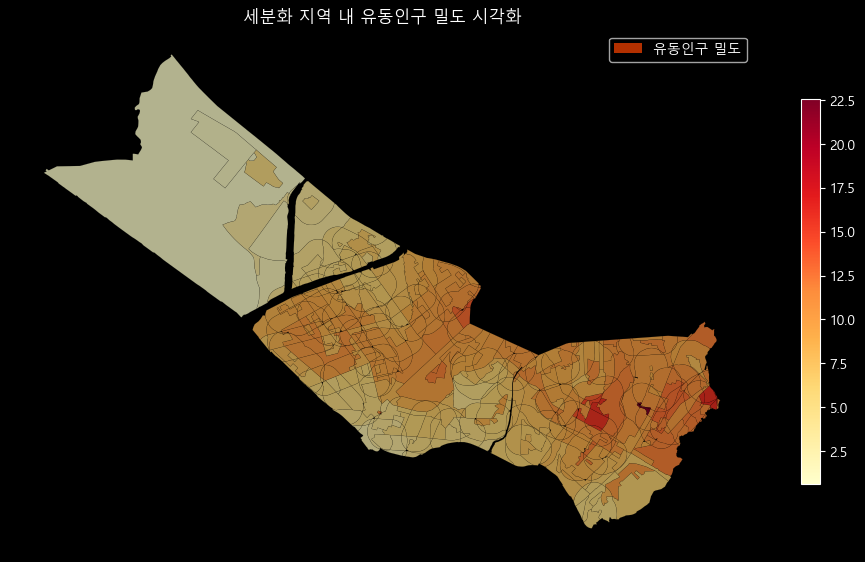

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
# mdf.merged_df.plot(ax=ax, edgecolor='black', linewidth=0.3, facecolor='none', alpha=0.3)
mdf.merged_df.plot(ax=ax, edgecolor='black', linewidth=0.1, column='총_유동인구_수_밀도_평균', cmap='YlOrRd', legend=True, alpha=0.7,
                   legend_kwds={
                     'shrink': 0.5,
                     'aspect': 20,
                     'orientation': "vertical"
                   })
ax.axis('off')
legend_elements = [
    Patch(facecolor='#FF4500', alpha=0.7, label='유동인구 밀도'),
]
ax.legend(handles=legend_elements)
ax.axis('off')
title = "세분화 지역 내 유동인구 밀도 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

## Connect location data

In [20]:
toilet_df = pd.read_csv(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시 공중화장실 위치정보.csv'), encoding='cp949')
park_df = pd.read_csv(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시 녹지대 위치정보.csv'), encoding='cp949')
subway_df = pd.read_csv(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시 역사마스터 정보.csv'), encoding='cp949')
bus_df = pd.read_excel(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시버스정류소위치정보.xlsx'))

In [21]:
toilet_gdf = gpd.GeoDataFrame(
  toilet_df,
  geometry=gpd.points_from_xy(toilet_df['x 좌표'], toilet_df['y 좌표']),
  crs="EPSG:4326"
)
park_gdf = gpd.GeoDataFrame(
  park_df,
  geometry=gpd.points_from_xy(park_df['X 좌표'], park_df['Y 좌표']),
  crs="EPSG:5181"
)
subway_gdf = gpd.GeoDataFrame(
  subway_df,
  geometry=gpd.points_from_xy(subway_df['경도'], subway_df['위도']),
  crs="EPSG:4326"
)
bus_gdf = gpd.GeoDataFrame(
  bus_df,
  geometry=gpd.points_from_xy(bus_df['X좌표'], bus_df['Y좌표']),
  crs="EPSG:4326"
)
toilet_gdf = toilet_gdf.to_crs(epsg=5181)
subway_gdf = subway_gdf.to_crs(epsg=5181)
bus_gdf = bus_gdf.to_crs(epsg=5181)

In [22]:
toilet_gdf_col = toilet_gdf.columns
park_gdf_col = park_gdf.columns
subway_gdf_col = subway_gdf.columns
bus_gdf_col = bus_gdf.columns

toilet_gdf_mapo = toilet_gdf.sjoin(gu_mapo, how='inner', predicate='within')[toilet_gdf_col]
park_gdf_mapo = park_gdf.sjoin(gu_mapo, how='inner', predicate='within')[park_gdf_col]
subway_gdf_mapo = subway_gdf.sjoin(gu_mapo, how='inner', predicate='within')[subway_gdf_col]
bus_gdf_mapo = bus_gdf.sjoin(gu_mapo, how='inner', predicate='within')[bus_gdf_col]

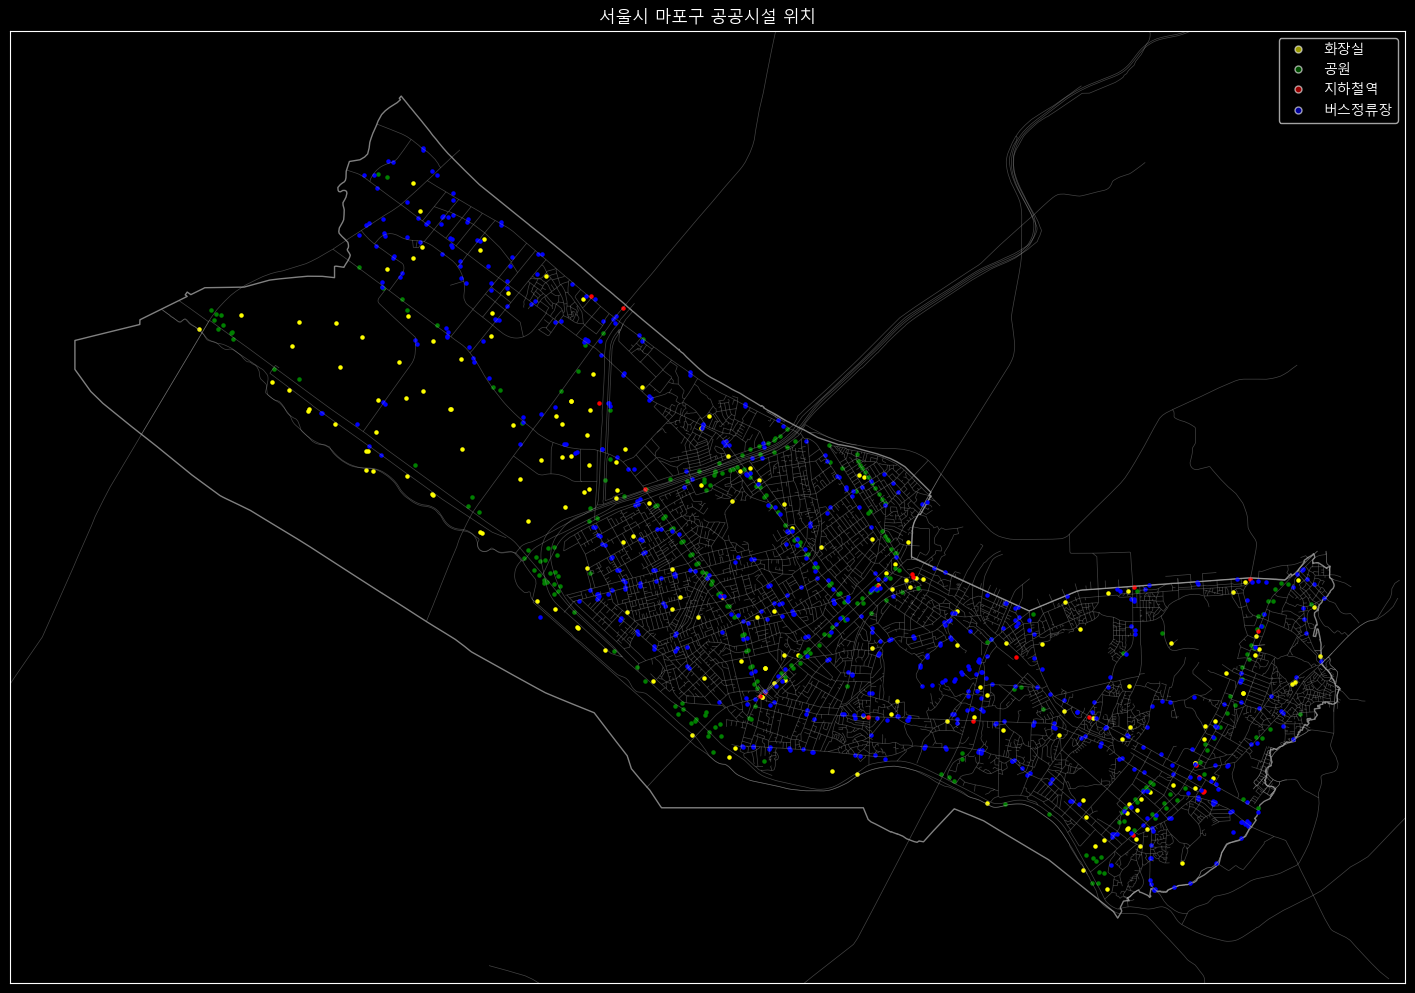

In [32]:
fig, ax = plt.subplots(figsize=(18, 15))
road_mapo.plot(ax=ax, color='darkgray', linewidth=0.5, alpha=0.4)
gu_mapo.plot(ax=ax, color='none', edgecolor='gray')
toilet_gdf_mapo.plot(ax=ax, color='yellow', markersize=5)
park_gdf_mapo.plot(ax=ax, color='green', markersize=5)
subway_gdf_mapo.plot(ax=ax, color='red', markersize=5)
bus_gdf_mapo.plot(ax=ax, color='blue', markersize=5)
# all_segmented_final.set_geometry('rep_point').plot(ax=ax, color='red', markersize=8, marker='*')
legend_elements = [
  Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow',
           markersize=5, linestyle='None', alpha=0.6, label='화장실'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
           markersize=5, linestyle='None', alpha=0.6, label='공원'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
           markersize=5, linestyle='None', alpha=0.6, label='지하철역'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
           markersize=5, linestyle='None', alpha=0.6, label='버스정류장')
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "서울시 마포구 공공시설 위치"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

### 고려사항
- 계산 반경 - 지하철: 800m/1200m(역세권 반경 고려), 버스: 400m/800m, 공원: 300m/600m, 화장실: 400m/800m

    - Distributions of walking access to public transport in Melbourne, Australia – Evidence on acceptable and tolerable walking distances
    > Many developed countries have adopted the 400 m (0.25 mile) and 800 m (0.5 mile) distances, respectively, as default planning goals for bus and rail transit (walking) catchment areas.

    - Assessing park accessibility in the city of Seoul: Walk or cycle to the park?
    > More rigorously, the UK government agency ‘English Nature’, stresses on the fact that “people living in towns and cities should have an accessible natural green space less than 300m from home”

    - Optimal layout of tourist toilets using resilience theory: An empirical study on Dunhua City in ethnic region of China
    > Optimizing the layout of tourist toilets is key to both meeting the sanitation demand of the visiting public and building an inclusive and civilized society.

    - How far and discernible are public toilets? A city-scale study using spatial analytics and deep learning in Nanjing, China
    > The results indicate an average toilet density of 0.91 units per km2, with 10-min catchment areas covering 27.47% of the city space, 71.36% of the population, and 82.00% of public service points of interest in Nanjing

In [23]:
public_df = {
  '지하철':subway_gdf_mapo,
  '버스':bus_gdf_mapo,
  '공원':park_gdf_mapo,
  '화장실':toilet_gdf_mapo,
}
public_source_dict = {
  '지하철':[800, 1200],
  '버스':[400, 800],
  '공원':[300, 600],
  '화장실':[400, 800],
}

In [24]:
pmdf = BufferMergeDF(all_segmented_final)
pmdf.reset()

for k, v_list in source_dict.items():
  for v in v_list:
    pmdf.run([commerce_df[k], hinterland_df[k], dong_df[k]], v)
for pk, r_list in public_source_dict.items():
  for r in r_list:
    pmdf.buffer_merge(public_df[pk], pk, r)

In [25]:
pmdf.merged_df

,geometry,rep_point,TRDAR_CD,ALLEY_TRDA,ADSTRD_CD,area_m2,총_유동인구_수_밀도_평균,총_상주인구_수_밀도_평균,총_가구_수_밀도_평균,월_평균_소득_금액_밀도_평균,...,총_직장_인구_수_밀도_평균,집객시설_수_밀도_평균,지하철_수_800m,지하철_수_1200m,버스_수_400m,버스_수_800m,공원_수_300m,공원_수_600m,화장실_수_400m,화장실_수_800m
0,"POLYGON ((193830.531 450892.687, 193885.91 450...",POINT (193830.762 450794.549),[3110566],"[3110566, 3110569]",11440660,39080.152375,9.668006,0.014702,0.009410,8.860344,...,0.011392,0.000208,4,6,12,72,1,14,5,15
1,"POLYGON ((193964.714 450827.456, 193965.917 45...",POINT (193972.339 450702.558),[3110569],"[3110566, 3110569]",11440660,26796.059766,10.041025,0.018598,0.012541,12.562896,...,0.010232,0.000174,4,6,21,74,0,5,2,16
2,"POLYGON ((193875.713 450674.267, 193871.974 45...",POINT (193739.434 450572.616),[3110566],"[3110565, 3110569, 3110566]",11440660,47636.521749,9.224680,0.014394,0.009183,9.326734,...,0.011034,0.000201,4,6,18,88,1,14,6,17
3,"POLYGON ((193871.974 450668.023, 193875.713 45...",POINT (193883.598 450623.053),[3110569],"[3110565, 3110569, 3110566]",11440660,7228.140944,9.597699,0.018290,0.012313,13.029286,...,0.009875,0.000166,4,6,18,82,0,9,3,16
4,"POLYGON ((193831.916 450577.561, 193834.499 45...",POINT (193802.049 450509.418),[3110569],"[3110565, 3110569, 3110566]",11440655,13420.807714,7.543497,0.019054,0.012025,13.369905,...,0.005499,0.000130,5,6,27,88,0,7,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,"POLYGON ((192092.561 449688.953, 192095.726 44...",POINT (192164.399 449736.254),[],"[3110550, 3110556]",11440680,4525.267767,3.707351,0.013466,0.007487,4.228868,...,0.004012,0.000082,2,4,13,37,11,28,5,14
805,"POLYGON ((192677.035 449355.947, 192674.68 449...",POINT (192651.727 449324.448),[],[3110556],11440655,2514.594653,3.197143,0.012658,0.006547,5.647564,...,0.002132,0.000081,3,3,7,33,0,1,1,9
806,"POLYGON ((191576.86 450088.88, 191577.261 4500...",POINT (191561.54 450048.353),[3110546],[3110546],11440680,5371.521071,4.699173,0.017582,0.009668,11.439207,...,0.002658,0.000053,1,3,7,29,6,16,2,13
807,"POLYGON ((191570.803 450236.394, 191579.244 45...",POINT (191552.675 450158.886),[3110546],"[3110546, 3110544]",11440680,7129.359890,5.729840,0.020062,0.010967,10.858165,...,0.003410,0.000070,1,3,11,50,2,12,2,13


## Connect store data

In [26]:
# 즉석판매제조가공업, 건강기능식품일반판매업(영업장판매), 미용업, 일반음식점, 휴게음식점(커피숍, 편의점)
instant = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_22_19_P_즉석판매제조가공업.csv'), encoding='cp949', low_memory=False)
health = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_22_03_P_건강기능식품일반판매업.csv'), encoding='cp949', low_memory=False)
beauty = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_05_18_01_P_미용업.csv'), encoding='cp949', low_memory=False)
food = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_24_04_P_일반음식점.csv'), encoding='cp949', low_memory=False)
coff_conv = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_24_05_P_휴게음식점.csv'), encoding='cp949', low_memory=False)

In [27]:
instant_df = instant[instant['영업상태명']=='영업/정상']
health_df = health[health['영업상태명']=='영업/정상']
health_df = health_df[health_df['위생업태명']=='영업장판매']
beauty_df = beauty[beauty['영업상태명']=='영업/정상']
food_df = food[food['영업상태명']=='영업/정상']
coff_conv_df = coff_conv[coff_conv['영업상태명']=='영업/정상']
coff_df = coff_conv_df[coff_conv_df['업태구분명']=='커피숍']
conv_df = coff_conv_df[coff_conv_df['업태구분명']=='편의점']

In [28]:
instant_gdf = gpd.GeoDataFrame(
  instant_df,
  geometry=gpd.points_from_xy(instant_df['좌표정보x(epsg5174)'], instant_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
health_gdf = gpd.GeoDataFrame(
  health_df,
  geometry=gpd.points_from_xy(health_df['좌표정보x(epsg5174)'], health_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
beauty_gdf = gpd.GeoDataFrame(
  beauty_df,
  geometry=gpd.points_from_xy(beauty_df['좌표정보x(epsg5174)'], beauty_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
food_gdf = gpd.GeoDataFrame(
  food_df,
  geometry=gpd.points_from_xy(food_df['좌표정보x(epsg5174)'], food_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
coff_gdf = gpd.GeoDataFrame(
  coff_df,
  geometry=gpd.points_from_xy(coff_df['좌표정보x(epsg5174)'], coff_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
conv_gdf = gpd.GeoDataFrame(
  conv_df,
  geometry=gpd.points_from_xy(conv_df['좌표정보x(epsg5174)'], conv_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)

instant_gdf = instant_gdf.to_crs(epsg=5181)
health_gdf = health_gdf.to_crs(epsg=5181)
beauty_gdf = beauty_gdf.to_crs(epsg=5181)
food_gdf = food_gdf.to_crs(epsg=5181)
coff_gdf = coff_gdf.to_crs(epsg=5181)
conv_gdf = conv_gdf.to_crs(epsg=5181)

In [29]:
instant_gdf_col = instant_gdf.columns
health_gdf_col = health_gdf.columns
beauty_gdf_col = beauty_gdf.columns
food_gdf_col = food_gdf.columns
coff_gdf_col = coff_gdf.columns
conv_gdf_col = conv_gdf.columns

instant_gdf_mapo = instant_gdf.sjoin(gu_mapo, how='inner', predicate='within')[instant_gdf_col]
health_gdf_mapo = health_gdf.sjoin(gu_mapo, how='inner', predicate='within')[health_gdf_col]
beauty_gdf_mapo = beauty_gdf.sjoin(gu_mapo, how='inner', predicate='within')[beauty_gdf_col]
food_gdf_mapo = food_gdf.sjoin(gu_mapo, how='inner', predicate='within')[food_gdf_col]
coff_gdf_mapo = coff_gdf.sjoin(gu_mapo, how='inner', predicate='within')[coff_gdf_col]
conv_gdf_mapo = conv_gdf.sjoin(gu_mapo, how='inner', predicate='within')[conv_gdf_col]

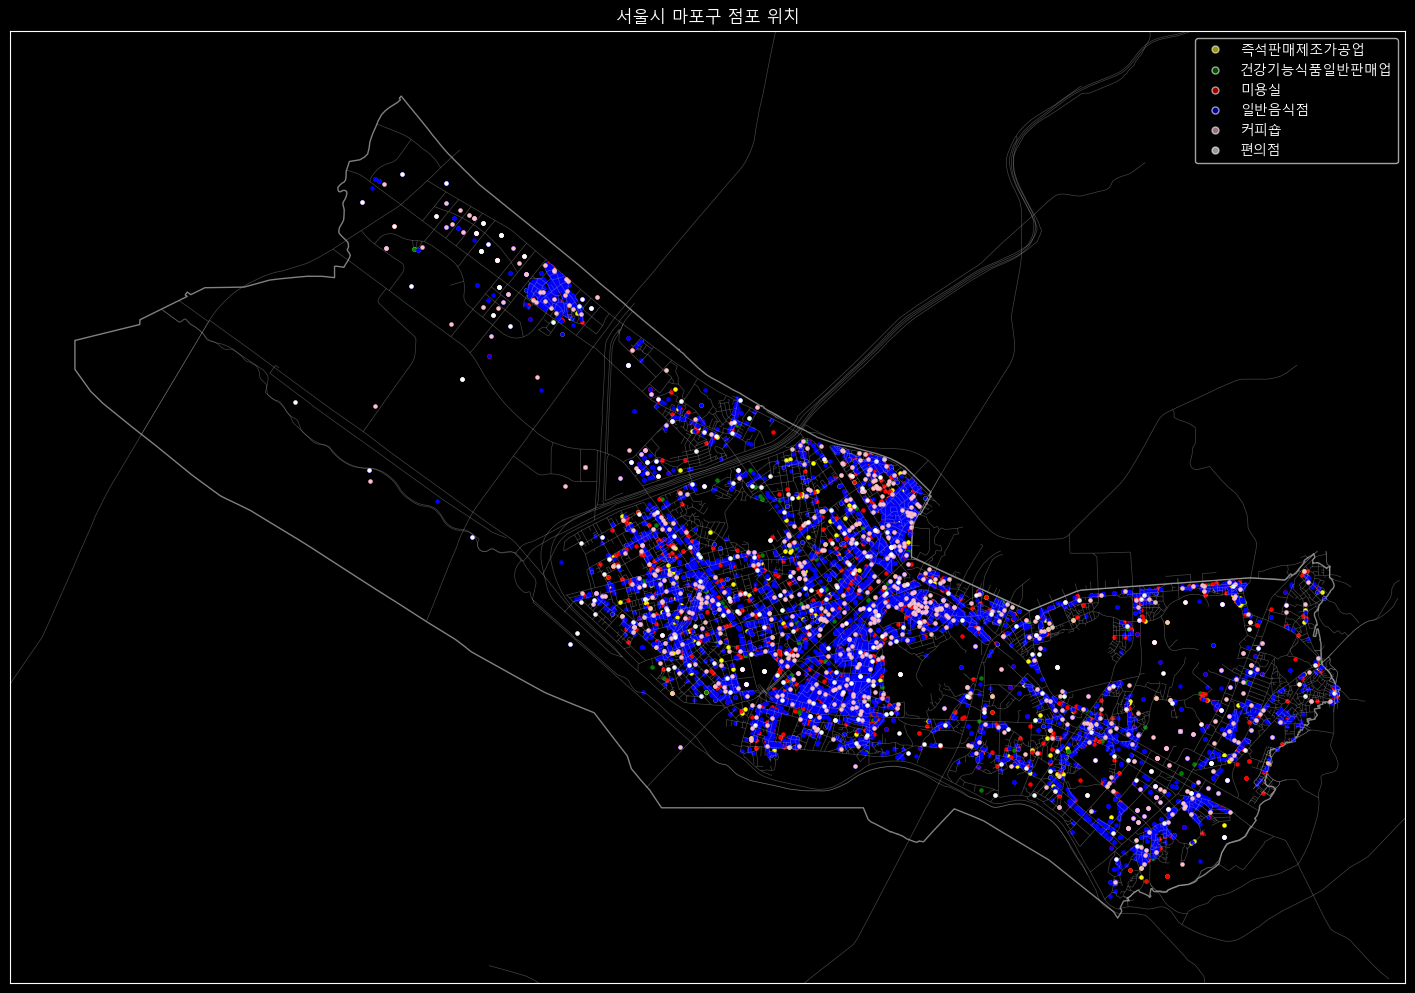

In [43]:
fig, ax = plt.subplots(figsize=(18, 15))
road_mapo.plot(ax=ax, color='darkgray', linewidth=0.5, alpha=0.4)
gu_mapo.plot(ax=ax, color='none', edgecolor='gray')
# conv_gdf_mapo.buffer(400).plot(ax=ax, color='lightcyan', alpha=0.3, edgecolor='blue', linestyle='--')
instant_gdf_mapo.plot(ax=ax, color='yellow', markersize=5)
health_gdf_mapo.plot(ax=ax, color='green', markersize=5)
beauty_gdf_mapo.plot(ax=ax, color='red', markersize=5)
food_gdf_mapo.plot(ax=ax, color='blue', markersize=5)
coff_gdf_mapo.plot(ax=ax, color='pink', markersize=5)
conv_gdf_mapo.plot(ax=ax, color='white', markersize=5)
# all_segmented_final.set_geometry('rep_point').plot(ax=ax, color='red', markersize=8, marker='*')
legend_elements = [
    Patch(facecolor='yellow', label='즉석판매제조가공업'),
    Patch(facecolor='green', label='건강기능식품일반판매업'),
    Patch(facecolor='red', label='미용실'),
    Patch(facecolor='blue', label='일반음식점'),
    Patch(facecolor='pink', label='커피숍'),
    Patch(facecolor='white', label='편의점'),
    # Patch(facecolor='red', label='중심점')
]
legend_elements = [
  Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow',
           markersize=5, linestyle='None', alpha=0.6, label='즉석판매제조가공업'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
           markersize=5, linestyle='None', alpha=0.6, label='건강기능식품일반판매업'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
           markersize=5, linestyle='None', alpha=0.6, label='미용실'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
           markersize=5, linestyle='None', alpha=0.6, label='일반음식점'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='pink',
           markersize=5, linestyle='None', alpha=0.6, label='커피숍'),
  Line2D([0], [0], marker='o', color='w', markerfacecolor='white',
           markersize=5, linestyle='None', alpha=0.6, label='편의점')
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
title = "서울시 마포구 점포 위치"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

In [30]:
# 즉석판매제조가공업, 건강기능식품일반판매업(영업장판매), 미용업, 일반음식점, 휴게음식점(커피숍, 편의점)
store_df = {
  '즉석판매제조가공업':instant_gdf_mapo,
  '건강기능식품일반판매업':health_gdf_mapo,
  '미용업':beauty_gdf_mapo,
  '일반음식점':food_gdf_mapo,
  '커피숍':coff_gdf_mapo,
  '편의점':conv_gdf_mapo,
}
store_source_dict = {
  '즉석판매제조가공업':[500, 1000],
  '건강기능식품일반판매업':[500, 1000],
  '미용업':[500, 1000],
  '일반음식점':[500, 1000],
  '커피숍':[500, 1000],
  '편의점':[500, 1000],
}

In [31]:
bmdf = BufferMergeDF(all_segmented_final)
bmdf.reset()

for k, v_list in source_dict.items():
  for v in v_list:
    bmdf.run([commerce_df[k], hinterland_df[k], dong_df[k]], v)
for pk, r_list in public_source_dict.items():
  for r in r_list:
    bmdf.buffer_merge(public_df[pk], pk, r)
for sk, r_list in store_source_dict.items():
  for r in r_list:
    bmdf.buffer_merge(store_df[sk], sk, r)

In [32]:
bmdf.merged_df

,geometry,rep_point,TRDAR_CD,ALLEY_TRDA,ADSTRD_CD,area_m2,총_유동인구_수_밀도_평균,총_상주인구_수_밀도_평균,총_가구_수_밀도_평균,월_평균_소득_금액_밀도_평균,...,건강기능식품일반판매업_수_500m,건강기능식품일반판매업_수_1000m,미용업_수_500m,미용업_수_1000m,일반음식점_수_500m,일반음식점_수_1000m,커피숍_수_500m,커피숍_수_1000m,편의점_수_500m,편의점_수_1000m
0,"POLYGON ((193830.531 450892.687, 193885.91 450...",POINT (193830.762 450794.549),[3110566],"[3110566, 3110569]",11440660,39080.152375,9.668006,0.014702,0.009410,8.860344,...,26,88,176,611,588,2313,78,230,9,46
1,"POLYGON ((193964.714 450827.456, 193965.917 45...",POINT (193972.339 450702.558),[3110569],"[3110566, 3110569]",11440660,26796.059766,10.041025,0.018598,0.012541,12.562896,...,21,74,151,541,479,2067,66,210,7,41
2,"POLYGON ((193875.713 450674.267, 193871.974 45...",POINT (193739.434 450572.616),[3110566],"[3110565, 3110569, 3110566]",11440660,47636.521749,9.224680,0.014394,0.009183,9.326734,...,29,102,210,706,703,2724,88,256,13,57
3,"POLYGON ((193871.974 450668.023, 193875.713 45...",POINT (193883.598 450623.053),[3110569],"[3110565, 3110569, 3110566]",11440660,7228.140944,9.597699,0.018290,0.012313,13.029286,...,21,90,167,593,550,2362,73,226,9,47
4,"POLYGON ((193831.916 450577.561, 193834.499 45...",POINT (193802.049 450509.418),[3110569],"[3110565, 3110569, 3110566]",11440655,13420.807714,7.543497,0.019054,0.012025,13.369905,...,21,101,184,661,589,2524,78,251,9,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,"POLYGON ((192092.561 449688.953, 192095.726 44...",POINT (192164.399 449736.254),[],"[3110550, 3110556]",11440680,4525.267767,3.707351,0.013466,0.007487,4.228868,...,24,71,120,425,433,1680,36,135,10,42
805,"POLYGON ((192677.035 449355.947, 192674.68 449...",POINT (192651.727 449324.448),[],[3110556],11440655,2514.594653,3.197143,0.012658,0.006547,5.647564,...,1,54,47,368,143,1421,14,94,2,33
806,"POLYGON ((191576.86 450088.88, 191577.261 4500...",POINT (191561.54 450048.353),[3110546],[3110546],11440680,5371.521071,4.699173,0.017582,0.009668,11.439207,...,7,62,42,310,233,1196,25,122,8,39
807,"POLYGON ((191570.803 450236.394, 191579.244 45...",POINT (191552.675 450158.886),[3110546],"[3110546, 3110544]",11440680,7129.359890,5.729840,0.020062,0.010967,10.858165,...,9,66,59,332,297,1235,34,128,11,43


In [34]:
bmdf.merged_df.to_csv(os.path.join(config.PROJECT_ROOT, 'preprocessed_data', '유동인구_학습용_데이터2.csv'), index=False, encoding='cp949')